In [1]:
## code was written using Python 2.7.13 ##
import numpy as np #v1.14.4
import seaborn as sns #v0.7.1
import matplotlib as plt #v1.5.1
import matplotlib.pyplot as plt
from pylab import *
import scipy as sc #v0.19.0
from scipy import stats
import pandas as pd #0.23.0
%matplotlib inline
import os
import csv

In [534]:
##EDIT THIS SECTION.

## open multiple files called 'extractedsignals.npy' and combine into single array.
## the best way to do this is to point the basedir to a folder. Within that folder there are multiple folders (named to identify
## session,mouse,FOV,etc), which each contain EXACTLY 1 file called EXACTLY 'extractedsignals.npy'

%cd 'C:\Users\Stuber Lab\Desktop\Raw data\satiety imaging'

basedir = '\\Users\\Stuber Lab\\Desktop\\Raw data\\satiety imaging\\Pre sated'

filename='TEST_RAW_DATA_BASELINE_sated'   #Used as prefix for files created by this program

maxnumneurons = 1000 #just used to initialize arrays. Should be larger than the total number of neurons
maxframes=3000       #number of frames

## Do you want to use F/F0 or z-scored data?
use_raw_data=['yes'] ## if 'no' then data will be z-scored
raw_threshold=1.1  #define raw threshold value for identifying events
z_threshold=1.5      #define z threshold value for identifying events

framerate=5 #framerate in Hz

### Filter the event by duration or area under the curve (values of 0 = unfiltered)
timethreshold=2  #threshold for duration of event (in seconds) 
areathreshold=0  #threshold for area under the curve of event

#do you want to use the low-pass filter to adjust the z-score values?
low_pass_filter_on=['no'] #either 'yes' or 'no'
lowpass_filter=1.1 # Change this to modify the low-pass correction. (values between 1.05 and 1.1 seem to work well)

#do you want to PLOT all individual traces? (if you have a lot of cells, this can be pretty time consuming)
plot_traces=['no'] ##plot unfiltered traces?
plot_traces_filtered=['no'] ##plot filtered traces?

#do you want to EXPORT individual traces? plot_traces must equal 'yes' in order to export traces.
export_traces=['no']

# do you want to export data files?
export_files=['yes']

## if you want to limit your analysis to a certain range of frames, change start_frame and end_frame below
start_frame=0 
end_frame=3000

bin_avg=3 #rolling average smooth; greater values increase the smoothing

C:\Users\Stuber Lab\Desktop\Raw data\satiety imaging


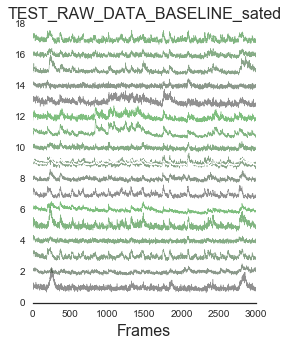

In [535]:
##plot time series for subset neurons (Fig. 3D)###
extractedsignals=np.load('C:\\Users\\Stuber Lab\\Desktop\\Raw data\\satiety imaging\\sample time series\\extractedsignals.npy') #file to be loaded
extractedsignals=np.squeeze(extractedsignals) #remove 'channels' dimension

#add constants to each neuron to offset for plotting
signals_adjusted=np.nan*np.zeros((extractedsignals.shape))
for i in range(extractedsignals.shape[0]):
    signals_adjusted[i,:]=extractedsignals[i,:]+i

## to plot only a subset of neurons ##
keep_traces=[12,13,15,20,28,30,31,33,34,38,39,40,41,42,43,45,46]
temp_keep=extractedsignals[keep_traces]
signals_adjusted2=np.nan*np.zeros((temp_keep.shape))
for i in range(temp_keep.shape[0]):
    signals_adjusted2[i,:]=temp_keep[i,:]+i
    
##plot time series for subset neurons
pal=sns.dark_palette("green")
sns.set(style="white",rc={"lines.linewidth": .5})
fig1,ax=plt.subplots(1,figsize=(4,5))
fig1=sns.tsplot(data=signals_adjusted2,err_palette=pal,err_style='unit_traces',color='white')
plt.xlabel('Frames', fontsize='16')
plt.title(filename, fontsize='16')
sns.despine(ax=ax,left=True)
plt.savefig('time_series_subset.pdf',dpi=600)
plt.show()

In [536]:
signals_pop = np.nan*np.zeros((maxnumneurons,maxframes))
data_dirs = os.walk(basedir).next()[1]
numneuronstillnow = 0
for data_dir in data_dirs:
    signals=np.load(os.path.join(basedir,data_dir,'extractedsignals.npy'))
    numneurons=signals.shape[1]
    numframes=signals.shape[2]
    temp_signals=np.squeeze(signals)
    for a in range(0,numneurons):
        signals_pop[numneuronstillnow+a,:numframes]=temp_signals[a,:]
    numneuronstillnow += numneurons
extractedsignals=signals_pop[:numneuronstillnow,:numframes]
print 'files = '+str(data_dirs)
print '\nNumber of neurons = '+str(extractedsignals.shape[0])

## if you want to limit your analysis to a certain range of ROIs, change start_roi and end_roi below
start_roi=0
end_roi=extractedsignals.shape[0]

#save parameters to csv
params=['framerate = '+str(framerate),'z-threshold = '+str(z_threshold),'raw threshold = '+str(raw_threshold),
        'time threshold = '+str(timethreshold),
         'area threshold = '+str(areathreshold),'low pass filter on? = '+low_pass_filter_on[0],
         'low pass filter = '+str(lowpass_filter),'start frame = '+str(start_frame),'end frame = '+str(end_frame),
         'number of cells = '+str(extractedsignals.shape[0]), 'use raw data? = '+str(use_raw_data[0])]
with open(filename+'_parameters','wb') as myfile:
    out=csv.writer(myfile,delimiter=',')
    out.writerow(params)

files = ['B4 FOV1 sated', 'B4 FOV2 sated', 'B5 FOV1 sated', 'B5 FOV2 sated', 'B6 sated', 'G1 sated', 'G10 sated', 'G11 sated', 'G3 sated', 'G4 sated', 'G5 sated', 'G6 sated', 'G7 sated', 'G8 sated', 'G9 sated']

Number of neurons = 452


In [537]:
#zscore data
zscore_signals=stats.zscore(extractedsignals[:,:], axis=1)
numrois=zscore_signals.shape[0]
numframes=zscore_signals.shape[1]

if use_raw_data[0]=='yes':
    zscore_signals=extractedsignals
    y_axis='F/F0'
    threshold=raw_threshold
else:
    y_axis='z-scored intensity'
    threshold=z_threshold

print 'Number of ROIs = '+str(numrois)
print 'Number of Frames = '+str(numframes)

Number of ROIs = 452
Number of Frames = 3000


In [538]:
#restrict frames/ROIs to values defined above
zscore_signals=zscore_signals[start_roi:end_roi,start_frame:end_frame]
numrois=zscore_signals.shape[0]
numframes=zscore_signals.shape[1]
print 'Number of ROIs = '+str(numrois)
print 'Number of Frames = '+str(numframes)

Number of ROIs = 452
Number of Frames = 3000


In [539]:
##re-zscore data after removing high-amplitude events

## Correction is as follows:
## 1.    Lowpass filter Raw SIMA traces
## 2.    (Mean(raw) - Mean(filt)) / STD(raw) = Correction Constant
## 3.    Zscore (raw) - Correction Constant = Corrected z-score

zscore_signals_filt=np.nan*np.empty(zscore_signals.shape)
for a in range(0,zscore_signals.shape[0]):
    for b in range(0,zscore_signals.shape[1]):
        if extractedsignals[a,b]>lowpass_filter:
            zscore_signals_filt[a,b]=nan
        else:
            zscore_signals_filt[a,b]=extractedsignals[a,b]
            
zscore_signals_filt_mean=np.nanmean(zscore_signals_filt, axis=1)
zscore_signals_mean=np.nanmean(extractedsignals, axis=1)  
adjust_zscore=zscore_signals_filt_mean-zscore_signals_mean
extractedsignals_std=np.nanstd(extractedsignals, axis=1)
zscore_signals_filt_mean=np.nanmean(zscore_signals_filt, axis=1)
zscore_signals_filt_std=np.nanstd(extractedsignals, axis=1)
for a in range(0,zscore_signals.shape[0]):
    for b in range(0,zscore_signals.shape[1]):
        zscore_signals_filt[a,b]=(zscore_signals_filt[a,b]-zscore_signals_filt_mean[a])/(zscore_signals_filt_std[a])      
for a in range(0,zscore_signals.shape[0]):
    for b in range(0,zscore_signals.shape[1]):
        zscore_signals_filt[a,b]=zscore_signals[a,b]-(adjust_zscore[a]/extractedsignals_std[a])

In [540]:
##low pass filter##
if low_pass_filter_on[0]=='yes':
    zscore_signals=zscore_signals_filt  
else:
    zscore_signals=zscore_signals
print 'low-pass filter = '+low_pass_filter_on[0]

low-pass filter = no


In [541]:
## rolling mean smooth on the zscored data.##
zscore_signals_df=pd.DataFrame(zscore_signals[:,:])
# signals_smoothed=pd.rolling_mean(zscore_signals_df, bin_avg, axis=1)
signals_smoothed=zscore_signals_df.rolling(bin_avg,axis=1).mean()
signals_smoothed=pd.DataFrame.as_matrix(signals_smoothed)
signals_smoothed.shape

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


(452L, 3000L)

In [542]:
#### find 'up' and 'down' events.  up corresponds to rising edge
up=np.empty(signals_smoothed.shape)
up[:]=np.NAN
down=np.empty(signals_smoothed.shape)
down[:]=np.NAN
for a in range(0,numrois):
    for i in range(1,numframes-1):
        up[a,i]=signals_smoothed[a,i]>threshold and signals_smoothed[a,i-1]<threshold and signals_smoothed[a,i+1]>threshold
        down[a,i]=signals_smoothed[a,i]>threshold and signals_smoothed[a,i-1]>threshold and signals_smoothed[a,i+1]<threshold

In [543]:
#plot ts with unfiltered event borders overlayed in red and export if desired
if plot_traces[0]=='yes':
    uptimesthreshold=up*threshold
    downtimesthreshold=down*threshold
    uptimesthreshold[uptimesthreshold==0]=np.nan
    downtimesthreshold[downtimesthreshold==0]=np.nan    
    for a in range(0,numrois):
        fig,ax = plt.subplots(1)
        sns.tsplot(signals_smoothed[a,start_frame:end_frame])
        sns.tsplot(downtimesthreshold[a,start_frame:end_frame], c='r', interpolate=False)
        sns.tsplot(uptimesthreshold[a,start_frame:end_frame], c='c', interpolate=False)
        plt.xlabel('Frames', fontsize='16')
        plt.ylabel(y_axis, fontsize='16')
        plt.title('ROI numer '+str(a), fontsize='16')
        ax.set_axis_bgcolor('white')
        plt.show()
        if export_traces[0]=='yes':
            fig.savefig(filename+'_ROI_'+str(a)+'.png', format='png') #uncomment this line to save all traces
            fig.clf()

In [544]:
#Remove event if trace starts or ends in 'up' state
#if first nonzero element of combined is -1, then change it to 0, if the last nonzero is 1, make it zero
down=down*-1
combined=up+down #values of 1 indicates rise and -1 indicates fall
for a in range(0,numrois):
    firstup=np.nanargmax(combined[a,:])
    firstdown=np.nanargmin(combined[a,:])
    if firstdown<firstup:
        combined[a,firstdown]=0     
flipped=np.fliplr(combined)
for a in range(0,numrois):
    lastup=np.nanargmax(flipped[a,:])
    lastdown=np.nanargmin(flipped[a,:])
    if lastup<lastdown:
        flipped[a,lastup]=0
combined=np.fliplr(flipped)
test=abs(combined)*threshold
test[test==0]=np.nan

In [545]:
#append frame number to array
time=np.arange(numframes)
zscore_signals2=np.squeeze(signals_smoothed)
signals_with_time=np.vstack((zscore_signals2, time)) 
signals_with_time[-1,:]

#find frame number of 'up' and 'down' events.  Up corresponds to rising edge, down=falling edge
diff_down=np.empty(signals_with_time.shape)
diff_down[:]=np.NAN
diff_up=np.empty(signals_with_time.shape)
diff_up[:]=np.NAN
for a in range(0,numrois):
    for i in range(0,numframes):
        if combined[a,i]<0:
            diff_down[a,i]=signals_with_time[-1,i]
        if combined[a,i]>0:
            diff_up[a,i]=signals_with_time[-1,i]             
temp_up=np.empty([signals_with_time.shape[1],2])
temp_up[:]=np.NAN
temp_down=np.empty([signals_with_time.shape[1],2])
temp_down[:]=np.NAN
event_time=np.NAN*np.ones(signals_with_time.shape)
allevents=np.NAN*np.ones(signals_with_time.shape)
allareas=np.NAN*np.ones(signals_with_time.shape)
allpeak=np.NAN*np.ones(signals_with_time.shape)
for a in range(0,numrois):
    temp_up[:,0]=diff_up[a,:]
    temp_down[:,1]=diff_down[a,:]
    temp_up2=temp_up[~np.isnan(temp_up)]
    temp_down2 = temp_down[~np.isnan(temp_down)]
    event_time=temp_down2-temp_up2
    for q in range (0,event_time.shape[0]):
        area=np.NAN*np.ones(event_time.shape[0])
        placehold_frames=signals_smoothed[a,int(temp_up2[q]):int(temp_down2[q])]
        peak=np.max(placehold_frames)
        area=np.trapz(placehold_frames)#, x=None, dx=1)#, axis=-1)   
        allareas[a,q] = area 
        allpeak[a,q] = peak
    allevents[a,:event_time.shape[0]] = event_time
allevents=allevents/framerate
allevents_pre_filt=allevents
allareas_pre_filt=allareas
framethreshold=timethreshold
count_events=~np.isnan(allevents)
count_events=np.sum(count_events,axis=1);count_events=count_events[0:count_events.shape[0]-1]
event_dur_mean=np.nanmean(allevents,axis=1)
auc_mean=np.nanmean(allareas,axis=1)
peak_mean=np.nanmean(allpeak,axis=1)
allareasdurfilt=allareas
allevents_again=allevents
allareas_again=allareas
allpeak_again=allpeak

##find event times and export inter-event intervals
combine_time=np.vstack((up,time))
for a in range(0,numrois):
    for b in range(0,numframes):
        if combined[a,b]==1:
            combine_time[a,b]=combine_time[-1,b]
event_time=np.nan*np.zeros((combined.shape))
event_iei=np.nan*np.zeros((combined.shape))
combine_time[combine_time==0]=np.nan
for a in range(0,numrois):
    temp_time=combine_time[a,:]
    temp_time=temp_time[~isnan(temp_time)]
    temp_iei=np.diff(temp_time)
    event_time[a,0:temp_time.shape[0]]=temp_time
    event_iei[a,0:temp_iei.shape[0]]=temp_iei
event_iei=event_iei/framerate
event_iei_mean=np.nanmean(event_iei,axis=1) 
    
#remove nans from event arrays arrays
allevents2=allevents[~np.isnan(allevents)]
allareas2=allareas[~np.isnan(allareas)]
allpeak2=allpeak[~np.isnan(allpeak)]
alliei=event_iei[~np.isnan(event_iei)]

In [546]:
#filter data based on thresholds defined above
allevents_pre_filt[allevents_pre_filt<framethreshold]=np.nan
allareas_pre_filt[allareas_pre_filt<areathreshold]=np.nan
allevents_filt=allevents_pre_filt[~np.isnan(allevents_pre_filt)]
allareas_filt=allareas_pre_filt[~np.isnan(allareas_pre_filt)]

#filter peak amplitude, auc, and iei using the filtered duration data
peak_filt=allpeak
auc_durfilt=allareasdurfilt
event_frames_durfilt=event_time
iei_durfilt=np.nan*np.zeros((allevents.shape))
event_frames_durfilt=np.vstack((event_frames_durfilt,(np.nan*np.zeros((1,numframes)))))

for a in range(0,allevents.shape[0]):
    for b in range(0,allevents.shape[1]):
        if allevents[a,b]>0:
            peak_filt[a,b]=peak_filt[a,b]
            auc_durfilt[a,b]=auc_durfilt[a,b]
            event_frames_durfilt[a,b]=event_frames_durfilt[a,b]
        else:
            peak_filt[a,b]=np.nan 
            auc_durfilt[a,b]=np.nan
            event_frames_durfilt[a,b]=np.nan
peak_filt_mean=np.nanmean(peak_filt,axis=1)
auc_durfilt_mean=np.nanmean(auc_durfilt,axis=1)

for a in range(0,numrois):
    temp_frame_nums=event_frames_durfilt[a,:]
    temp_frame_nums=temp_frame_nums[~np.isnan(temp_frame_nums)]
    temp_iei=np.diff(temp_frame_nums)
    iei_durfilt[a,0:temp_iei.shape[0]]=temp_iei
iei_durfilt=iei_durfilt/framerate
iei_durfilt_mean=np.nanmean(iei_durfilt,axis=1)

print 'Number of events for duration filter = '+str(allevents_filt.shape[0])
print 'Number of events for area filter = '+str(allareas_filt.shape[0])
allpeakfilt=peak_filt[~np.isnan(peak_filt)]
alliei_durfilt=iei_durfilt[~np.isnan(iei_durfilt)]
count_dur_filt=~np.isnan(allevents)
count_dur_filt=np.sum(count_dur_filt,axis=1);count_dur_filt=count_dur_filt[0:count_dur_filt.shape[0]-1]
count_AUC_filt=~np.isnan(allareas)
count_AUC_filt=np.sum(count_AUC_filt,axis=1);count_AUC_filt=count_AUC_filt[0:count_AUC_filt.shape[0]-1]
dur_filt_mean=np.nanmean(allevents,axis=1)
auc_filt_mean=np.nanmean(allareas,axis=1)

Number of events for duration filter = 2514
Number of events for area filter = 17462


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


In [547]:
## save filtered data (Figs. S5g-i) ##
if export_files[0]=='yes':
    np.savetxt(filename+'_dur_filt_Avg.csv',dur_filt_mean,delimiter=',')
    np.savetxt(filename+'_AUC_filt_Avg.csv',auc_filt_mean,delimiter=',')
    np.savetxt(filename+'_Num_events_dur_filt.csv',count_dur_filt,delimiter=',',fmt='%i')
    np.savetxt(filename+'_Amplitude_filt_AVG.csv',peak_filt_mean,delimiter=',')
    np.savetxt(filename+'_iei_durfilt_Avg.csv',iei_durfilt_mean,delimiter=',')